# Accessing ICESat-2 Data
This notebook ({nb-download}`download <IS2_data_access.ipynb>`) illustrates the use of icepyx for programmatic ICESat-2 data query and download from the NASA NSIDC DAAC (NASA National Snow and Ice Data Center Distributed Active Archive Center).
A complimentary notebook demonstrates in greater detail the [subsetting](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access2-subsetting.html) options available when ordering data.

In [ ]:
%mamba uninstall -y icepyx

In [ ]:
pip install git+https://github.com/icesat2py/icepyx.git@harmony-take2

Import packages, including icepyx

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
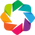

In [1]:
import icepyx as ipx
import os
import shutil
%matplotlib inline

---------------------------------

## Quick-Start Guide

The entire process of getting ICESat-2 data (from query to download) can ultimately be accomplished in two minimal lines of code:

`region_a = ipx.Query(short_name, spatial_extent, date_range)`

`region_a.download_granules(path)`

where the function inputs are described in more detail below.

**The rest of this notebook explains the required inputs used above, optional inputs not available in the minimal example, and the other data search and visualization tools built in to icepyx that make it easier for the user to find, explore, and download ICESat-2 data programmatically from NSIDC.** The detailed steps outlined and the methods showcased below are meant to give the user more control over the data they find and download (including options to order/download only the relevant portions of a data granule), some of which are called using default values behind the scenes if the user simply skips to the `download_granules` step.

## Key Steps for Programmatic Data Access

There are several key steps for accessing data from the NSIDC API:
1. Define your parameters (spatial, temporal, dataset, etc.)
2. Query the NSIDC API to find out more information about the dataset
4. Define additional parameters (e.g. subsetting/customization options)
5. Order your data
6. Download your data

icepyx streamlines this process into a minimal number of lines of code.

### Create an ICESat-2 data object with the desired search parameters

There are three required inputs, depending on how you want to search for data. Two are required in all cases:
- `short_name` = the data product of interest, known as its "short name".
See https://nsidc.org/data/icesat-2/products for a list of the available data products.
- `spatial extent` = a region of interest to search within. This can be entered as a bounding box, polygon vertex coordinate pairs, or a polygon geospatial file (currently shp, kml, and gpkg are supported).
    - bounding box: Given in decimal degrees for the lower left longitude, lower left latitude, upper right longitude, and upper right latitude.
    - polygon vertices: Given as longitude, latitude coordinate pairs of decimal degrees with the last entry a repeat of the first.
    - polygon file: A string containing the full file path and name.
    
*NOTE: The input keyword for `short_name` was updated in the code from `dataset` to `product` to match common usage.
This should not affect users providing positional inputs as demonstrated in this tutorial.*

*NOTE: You can submit at most one bounding box or a list of lonlat polygon coordinates per object instance.
Per NSIDC requirements, geospatial polygon files may only contain one feature (polygon).*

Then, for all non-gridded products (ATL13 and lower), you must include AT LEAST one of the following inputs (temporal or orbital constraints):
- `date_range` = the date range for which you would like to search for results. The following formats are accepted: 
    - A list of two 'YYYY-MM-DD' strings separated by a comma
    - A list of two 'YYYY-DOY' strings separated by a comma
    - A list of two datetime.date or datetime.datetime objects
    - Dict with the following keys:
        - `start_date`: start date; type can be datetime.datetime, datetime.date, or strings (format 'YYYY-MM-DD' or 'YYYY-DOY')
        - `end_date`: end date; type can be datetime.datetime, datetime.date, or strings (format 'YYYY-MM-DD' or 'YYYY-DOY')
- `cycles` = Which orbital cycle to use, input as a numerical string or a list of strings. If no input is given, this value defaults to all available cycles within the search parameters.  An orbital cycle refers to the 91-day repeat period of the ICESat-2 orbit.
- `tracks` = Which [Reference Ground Track (RGT)](https://icesat-2.gsfc.nasa.gov/science/specs) to use, input as a numerical string or a list of strings. If no input is given, this value defaults to all available RGTs within the spatial and temporal search parameters.

Below are examples of each type of spatial extent and temporal input and an example using orbital parameters. Please choose and run only one of the input option cells to set your spatial and temporal parameters.

In [2]:
# bounding box
short_name = 'ATL06'
spatial_extent = [-55, 68, -48, 71]
date_range = ['2019-02-20','2019-02-28']

In [ ]:
# polygon vertices (here equivalent to the bounding box, above)
short_name = 'ATL06'
spatial_extent = [(-55, 68), (-55, 71), (-48, 71), (-48, 68), (-55, 68)]
date_range = ['2019-02-20','2019-02-28']

In [ ]:
# bounding box with 'YYYY-DOY' date range (equivalent to 'YYYY-MM-DD' date ranges above)
short_name = 'ATL06'
spatial_extent = [-55, 68, -48, 71]
date_range = ['2019-051','2019-059']

In [ ]:
# polygon vertices with datetime.datetime date ranges
import datetime as dt

start_dt = dt.datetime(2019, 2, 20, 0, 10, 0)
end_dt = dt.datetime(2019, 2, 28, 14, 45, 30)
short_name = 'ATL06'
spatial_extent = [(-55, 68), (-55, 71), (-48, 71), (-48, 68), (-55, 68)]
date_range = [start_dt, end_dt]

In [ ]:
# bounding box with dict containing date ranges
short_name = 'ATL06'
spatial_extent = [-55, 68, -48, 71]
date_range = {"start_date": start_dt, "end_date": '2019-02-28'}

In [ ]:
# polygon geospatial file (metadata match but no subset match)
# short_name = 'ATL06'
# spatial_extent = './supporting_files/data-access_PineIsland/glims_polygons.kml'
# date_range = ['2019-02-22','2019-02-28']

# #polygon geospatial file (subset and metadata match)
# short_name = 'ATL06'
# spatial_extent = './supporting_files/data-access_PineIsland/glims_polygons.shp'
# date_range = ['2019-10-01','2019-10-05']

#polygon geospatial file (same area as other examples; subset and metadata match)
short_name = 'ATL06'
spatial_extent = './supporting_files/simple_test_poly.gpkg'
date_range = ['2019-10-01','2019-10-05']

Create the data object using our inputs

In [ ]:
region_a = ipx.Query(short_name, spatial_extent, date_range)

In [ ]:
# using orbital parameters with one of the above data products + spatial parameters
region_a = ipx.Query(short_name, spatial_extent,
   cycles=['03','04','05','06','07'], tracks=['0849','0902'])

print(region_a.product)
print(region_a.product_version)
print(region_a.cycles)
print(region_a.tracks)

These properties include visualization of the spatial extent on a map. The style of map you will see depends on whether or not you have a certain library, `geoviews`, installed. Under the hood, this is because the `proj` library must be installed with conda (it is not available from PyPI) to support some `geoviews` dependencies. With `geoviews`, this plotting function returns an interactive map. Otherwise, your spatial extent will plot on a static map using `matplotlib`.

In [ ]:
# print(region_a.spatial_extent)
region_a.visualize_spatial_extent()

Formatted parameters and function calls allow us to see the the properties of the data object we have created.

In [ ]:
print(region_a.product)
print(region_a.temporal) # .dates, .start_time, .end_time can also be used for a piece of this information
# print(region_a.dates)
# print(region_a.start_time)
# print(region_a.end_time)
print(region_a.cycles)
print(region_a.tracks)
print(region_a.product_version)
region_a.visualize_spatial_extent()

There are also several optional inputs to allow the user finer control over their search. Start and end time are only valid inputs on a temporally limited search, and they are ignored if your `date_range` input is a datetime.datetime object.
- `start_time` = start time to search for data on the start date. If no input is given, this defaults to 00:00:00.
- `end_time` = end time for the end date of the temporal search parameter. If no input is given, this defaults to 23:59:59. 

Times must be input as 'HH:mm:ss' strings or datetime.time objects.

- `version` = What version of the data product to use, input as a numerical string. If no input is given, this value defaults to the most recent version of the product specified in `short_name`.

*NOTE Version 002 is used as an example in the below cell. However, using it will cause 'no results' errors in granule ordering for some search parameters. These issues have been resolved in later versions of the data products, so it is best to use the most recent version where possible.
Similarly, if you try to order/download a retired version no longer accessible at the NSIDC, you will get a "no data matched your request" error.
Thus, you will need to update the version associated with `region_a` and rerun the next cell for the rest of this notebook to run.*

In [ ]:
region_a = ipx.Query(short_name, spatial_extent, date_range, \
   start_time='03:30:00', end_time='21:30:00', version='002')

print(region_a.product)
print(region_a.dates)
print(region_a.product_version)
print(region_a.spatial)
print(region_a.temporal)

Alternatively, you can also just create the query object without creating named variables first:

In [ ]:
region_a = ipx.Query(short_name, spatial_extent, date_range, \
   start_time='03:30:00', end_time='21:30:00')

print(region_a.product)
print(region_a.dates)
print(region_a.product_version)
print(region_a.spatial)
print(region_a.temporal)

### More information about your query object
In addition to viewing the stored object information shown above (e.g. product short name, start and end date and time, version, etc.), we can also request summary information about the data product itself or confirm that we have manually specified the latest version.

In [ ]:
region_a.product_summary_info()
print(region_a.latest_version())

If the summary does not provide all of the information you are looking for, or you would like to see information for previous versions of the data product, all available metadata for the collection product is available in a readable format.

In [ ]:
region_a.product_all_info()

### Querying a data product
In order to search the product collection for available data granules, we need to build our search parameters. This is done automatically behind the scenes when you run `region_a.avail_granules()`, but you can also build and view them by calling `region_a.CMRparams`. These are formatted as a dictionary of key-value pairs according to the [CMR documentation](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html).

In [ ]:
#build and view the parameters that will be submitted in our query
region_a.CMRparams

Now that our parameter dictionary is constructed, we can search the CMR database for the available granules.
Granules returned by the CMR metadata search are automatically stored within the data object.
The search completed at this level relies completely on the granules' metadata.
As a result, some (and in rare cases all) of the granules returned may not actually contain data in your specified region, particularly if the region is small or located near the boundaries of a given granule. If this is the case, the subsetter will not return any data when you actually place the order.
A warning message will be issued during ordering for each granule to which this applies (but no message is output for successfully subsetted granules, so don't worry!)

In [ ]:
#search for available granules and provide basic summary info about them
region_a.avail_granules()

In [ ]:
#get a list of granule IDs for the available granules
region_a.avail_granules(ids=True)

### Log in to NASA Earthdata
When downloading data from NSIDC, all users must login using a valid (free) Earthdata account. The process of authenticating is handled by icepyx by creating and handling the required authentication to interface with the data at the DAAC (including ordering and download). Authentication is completed as login-protected features are accessed. In order to allow icepyx to login for us, we still have to ensure that we have made our Earthdata credentials available for icepyx to find.

There are multiple ways to provide your Earthdata credentials via icepyx. Behind the scenes, icepyx is using the [earthaccess library](https://nsidc.github.io/earthaccess/). The [earthaccess documentation](https://earthaccess.readthedocs.io/en/latest/tutorials/getting-started/#auth) automatically tries three primary mechanisms for logging in, all of which are supported by icepyx:
- with `EARTHDATA_USERNAME` and `EARTHDATA_PASSWORD` environment variables (these are the same as the ones you might have set for icepyx previously)
- through an interactive, in-notebook login (used below); passwords are not shown plain text with this option
- with stored credentials in a .netrc file (not recommended for security reasons)

#### Subsetting

For a deeper dive into subsetting, please see our [Subsetting Tutorial Notebook](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access2-subsetting.html), which covers subsetting in more detail.

Subsetting utilizes the NSIDC's built in subsetter to spatially and temporally extract the data you are interested. The advantages of using the NSIDC's subsetter include:
* easily reproducible downloads, particularly when coupled with an icepyx query object
* smaller file size, meaning faster downloads and less storage required
* easily order more data with the same or similar search parameters
* quickly move to analysis and easily navigate your dataset

In [ ]:
region_a.CMRparams

### Place the order
Then, we can send the order to NSIDC using the order_granules function. Information about the granules ordered and their status will be printed automatically. Status information can also be emailed to the address associated with your EarthData account when the `email` kwarg is set to `True`. Additional information on the order, including request URLs, can be viewed by setting the optional keyword input 'verbose' to True.

In [ ]:
order = region_a.order_granules()
# region_a.order_granules(verbose=True, subset=False, email=False)
order

In [ ]:
order.status()

### Download the order
Finally, we can download our order to a specified directory (which needs to have a full path but doesn't have to point to an existing directory) and the download status will be printed as the program runs. Additional information is again available by using the optional boolean keyword `verbose`.

In [ ]:
path = './download'
region_a.download_granules(path)

**Credits**
* original notebook by: Jessica Scheick
* notebook contributors: Amy Steiker and Tyler Sutterley
* source material: [NSIDC Data Access Notebook](https://github.com/ICESAT-2HackWeek/ICESat2_hackweek_tutorials/tree/master/03_NSIDCDataAccess_Steiker) by Amy Steiker and Bruce Wallin and [2020 Hackweek Data Access Notebook](https://github.com/ICESAT-2HackWeek/2020_ICESat-2_Hackweek_Tutorials/blob/main/06-07.Data_Access/02-Data_Access_rendered.ipynb) by Jessica Scheick and Amy Steiker